## AIML 2304 NLP Term Project

# Quora Duplicate Question Classifier

## Motivation

Quora is a question-answering platform that lets users ask questions and get answers on them. It connects users having the same problems and allows them to share knowledge with the public. This allows people to get knowledge quickly which makes their life easy. The most common issue which has been faced by Quora users is question duplication. Sometimes users ask similar questions which have been answered before which results in question duplication. This makes the writers feel like they have to answer the same questions multiple times which reduces quora's experience. Our aim is to resolve this problem by applying advanced NLP techniques to classify whether questions are repeated or not. This allows users to find good-quality answers easily.

## Source of Data

#### Data Source : https://www.kaggle.com/c/quora-question-pairs
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate <br>
- Size of Train.csv - 60MB <br>
- Number of rows in Train.csv = 404,290

#### Data fields

- id - the id of a training set question pair
- qid1, qid2 - unique ids of each question (only available in train.csv)
- question1, question2 - the full text of each question
- is_duplicate - the target variable, set to 1 if question1 and question2 have essentially the same meaning, and 0 otherwise.

#### Problem Statement
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 

It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not.
This could be useful to instantly provide answers to questions that have already been answered. 

### Modelling Method

We will be using different mechanisms to identify whether questions are similar or not. We will be analyzing common words, first and last words, and fuzz ratios for our analysis. We will also be using cosine similarity and Euclidean distance to see the similarity. Finally, we will be using SVC and Random Forest Classifiers to classify duplicate questions.

### Importing Required Libraries

In [81]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc
import time
import sys

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")
# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
import datetime as dt

from time import time
import scipy.stats as stats
from sklearn.utils.fixes import loguniform

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.datasets import load_digits
from sklearn.linear_model import SGDClassifier
from sklearn.base import BaseEstimator

## Exploratory Data Analysis

In [2]:
df = pd.read_csv("data/train.csv")

print("Total number of question pairs for training:",df.shape[0])

Total number of question pairs for training: 404290


In [3]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


### Distribution of data points among output classes

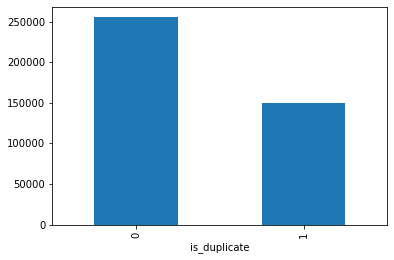

In [5]:
df.groupby("is_duplicate")['id'].count().plot.bar();

In [6]:
print(f'Question pairs are not Similar: {100 - round(df["is_duplicate"].mean()*100, 2)}%')
print(f'Question pairs are Similar: {round(df["is_duplicate"].mean()*100, 2)}%')

Question pairs are not Similar: 63.08%
Question pairs are Similar: 36.92%


### 1.2 Number of unique questions

In [7]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())

unique_qs = len(np.unique(qids))

qs_morethan_onetime = np.sum(qids.value_counts() > 1)

print (f'Total number of  Unique Questions: {unique_qs}\n')
#print len(np.unique(qids))

print (f'Number of unique questions that appear more than one time: {qs_morethan_onetime} ({round((qs_morethan_onetime/unique_qs*100), 2)}%)\n')

print (f'Max number of times a single question is repeated: {max(qids.value_counts())}\n') 

q_vals=qids.value_counts()

q_vals=q_vals.values

Total number of  Unique Questions: 537933

Number of unique questions that appear more than one time: 111780 (20.78%)

Max number of times a single question is repeated: 157



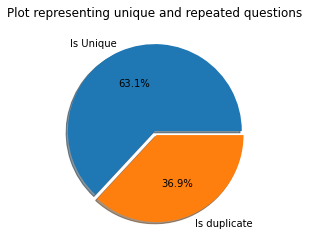

In [8]:
label = ["Is Unique", "Is duplicate"]
explode= [0, 0.05]

plt.pie(df.groupby("is_duplicate")['id'].count(), labels=label, explode=explode, autopct = "%0.1f%%", shadow=True)
plt.title ("Plot representing unique and repeated questions")
plt.show()

### 1.3 Checking for Duplicates

In [9]:
#checking whether there are any repeated (Exact same question wording repeatation) pair of questions
pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


### 1.4 Number of occurrences of each question

Maximum number of times a single question is repeated: 157



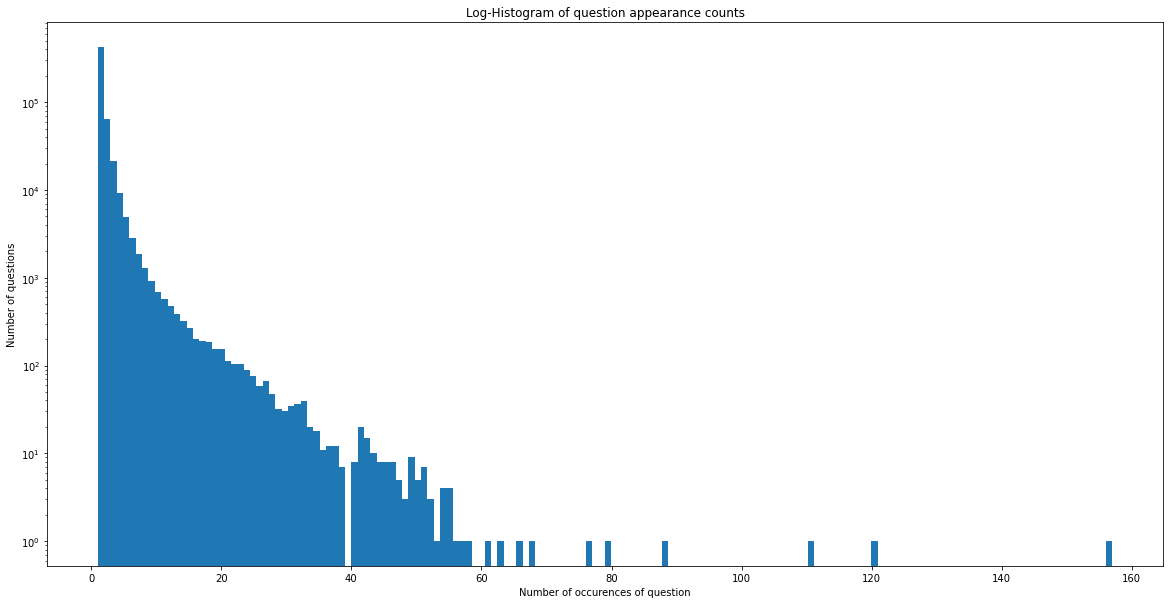

In [10]:
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

### 1.5 Checking for NULL values

In [11]:
#Checking whether there are any rows with null values
nan_rows = df[df.isnull().any(1)]

print (nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


- There are two rows with null values in question2 

In [12]:
# Filling the null values with ' '
df = df.fillna('')

# Rechecking for null values
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


### 1.6 Basic Feature Extraction (before cleaning)

Adding new features:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = Number of common unique words in Question 1 and Question 2
 - ____word_Total____ = Total num of words in Question 1 + Total num of words in Question 2
 - ____word_share____ = word_common/word_Total
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [13]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len() 
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    df['word_Common'] = df.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)

    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

    df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


### Analysis of the extracted features

- Here are some questions have only one single words.

In [14]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 67
Number of Questions with minimum length [question2] : 24


#### Feature: word_share

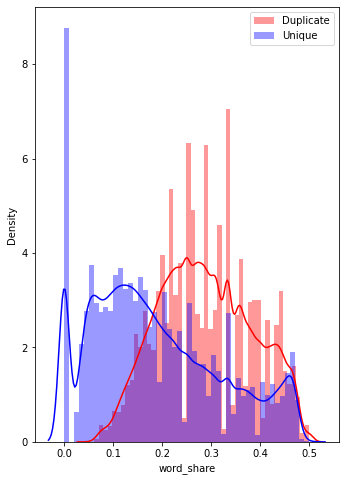

In [15]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "Duplicate", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "Unique" , color = 'blue' )
plt.legend()
plt.show()

- The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

#### Feature: word_Common

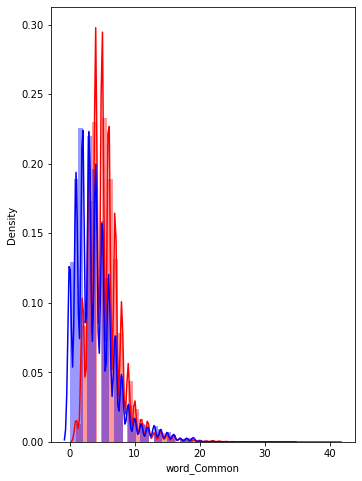

In [16]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

- The distributions of the word_Common feature in similar and non-similar questions are highly overlapping

In [17]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
    df = df.fillna('')
    df.head()
else:
    print("get df_fe_without_preprocessing_train.csv from drive or run the previous notebook")

df.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0


#### Preprocessing of Text

- Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions etc.

In [18]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    """
    Function to Compute and get the features : With 2 parameters of Question 1 and Question 2
    """
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x

### Advanced Feature Extraction (NLP and Fuzzy Features)

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>      
- __last_word_eq__ :  Check if Last word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))

In [19]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [20]:
if os.path.isfile('nlp_features_train.csv'):
    df = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
    df.fillna('')
else:
    print("Extracting features for train:")
    df = pd.read_csv("Data/train.csv")
    df = extract_features(df)
    df.to_csv("nlp_features_train.csv", index=False)
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


In [21]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s', encoding="utf-8")
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s', encoding="utf-8")

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [22]:
# reading the text files and removing the Stop Words:
d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt'), encoding="utf-8").read()
textn_w = open(path.join(d, 'train_n.txt'), encoding="utf-8").read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 16110763
Total number of words in non duplicate pair questions : 33201102


Word Cloud for Duplicate Question pairs


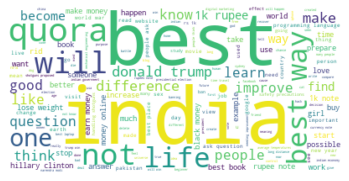

In [23]:
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Word Cloud for non-Duplicate Question pairs:


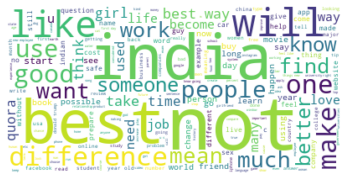

In [24]:
wc = WordCloud(background_color="white", max_words=len(textn_w),stopwords=stopwords)
# generate word cloud
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

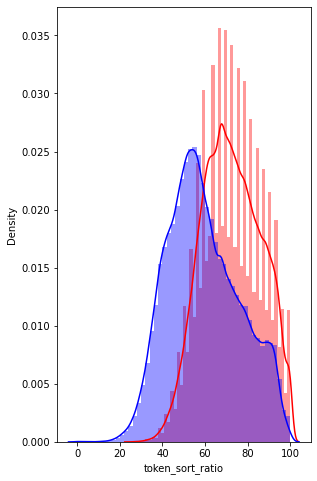

In [25]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

## Featurizing text data with tfidf weighted word-vectors

In [38]:
# Load Basic Features
df_basic_feature = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')

In [39]:


print("Columns : ",df_basic_feature.columns)
print("\nNumber of columns : ",len(df_basic_feature.columns))

df_basic_feature.head()



Columns :  Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words',
       'word_Common', 'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2'],
      dtype='object')

Number of columns :  17


,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [41]:
# Load Advance Features
df_advance_features = pd.read_csv("nlp_features_train.csv",encoding='latin-1')

print("Columns : ",df_advance_features.columns)
print("\nNumber of columns : ",len(df_advance_features.columns))

df_advance_features.head()

Columns :  Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio'],
      dtype='object')

Number of columns :  21


,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,0.399992,0.333328,0.399992,0.249997,...,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,2.0,12.0,36,36,35,40,0.039216
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,0.399992,0.199998,0.999950,0.666644,...,0.307690,0.0,1.0,6.0,10.0,67,47,46,56,0.175000


In [42]:
# Columns dropped from basic feature dataframe 
df_basic_feature = df_basic_feature.drop(['qid1','qid2'],axis=1)

# Columns dropped from advance feature dataframe 
df_advance_features = df_advance_features.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)

# Lets add both the truncated dataframe into one dataframe
df_basic_advance_features  = df_basic_feature.merge(df_advance_features, on='id',how='left')

### Checking for null value

In [43]:
nan_rows = df_basic_advance_features[df_basic_advance_features.isnull().any(1)]
print (nan_rows)

            id                         question1  \
105780  105780    How can I develop android app?   
201841  201841  How can I create an Android app?   
363362  363362                               NaN   

                                                question2  is_duplicate  \
105780                                                NaN             0   
201841                                                NaN             0   
363362  My Chinese name is Haichao Yu. What English na...             0   

        freq_qid1  freq_qid2  q1len  q2len  q1_n_words  q2_n_words  ...  \
105780          2          2     30      0           6           1  ...   
201841          1          2     32      0           7           1  ...   
363362          1          1      0    123           1          21  ...   

        ctc_max  last_word_eq  first_word_eq  abs_len_diff  mean_len  \
105780      0.0           0.0            0.0           0.0       0.0   
201841      0.0           0.0            0.0 

In [44]:
df_basic_advance_features = df_basic_advance_features[df_basic_advance_features['question1'].notnull()]
df_basic_advance_features = df_basic_advance_features[df_basic_advance_features['question2'].notnull()]

In [45]:
nan_rows = df_basic_advance_features[df_basic_advance_features.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, question1, question2, is_duplicate, freq_qid1, freq_qid2, q1len, q2len, q1_n_words, q2_n_words, word_Common, word_Total, word_share, freq_q1+q2, freq_q1-q2, cwc_min, cwc_max, csc_min, csc_max, ctc_min, ctc_max, last_word_eq, first_word_eq, abs_len_diff, mean_len, token_set_ratio, token_sort_ratio, fuzz_ratio, fuzz_partial_ratio, longest_substr_ratio]
Index: []

[0 rows x 30 columns]


In [46]:
print("\nNumber of columns : ",len(df_basic_advance_features.columns))

df_basic_advance_features.head()

Columns :  Index(['id', 'question1', 'question2', 'is_duplicate', 'freq_qid1',
       'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words',
       'word_Common', 'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2',
       'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio'],
      dtype='object')

Number of columns :  30


,id,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,...,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667
3,3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,...,0.000000,0.0,0.0,2.0,12.0,36,36,35,40,0.039216
4,4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,...,0.307690,0.0,1.0,6.0,10.0,67,47,46,56,0.175000


#### Specify our target value i.e dependent value

In [47]:
target = df_basic_advance_features['is_duplicate']



df_basic_advance_features.drop(['id','is_duplicate'], axis=1, inplace=True)

print("\nNumber of columns : ",len(df_basic_advance_features.columns))

df_basic_advance_features.head()


Number of columns :  28


,question1,question2,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,1,1,66,57,14,12,10.0,23.0,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,4,1,51,88,8,13,4.0,20.0,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,1,1,73,59,14,10,4.0,24.0,...,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,1,1,50,65,11,9,0.0,19.0,...,0.000000,0.0,0.0,2.0,12.0,36,36,35,40,0.039216
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,3,1,76,39,13,7,2.0,20.0,...,0.307690,0.0,1.0,6.0,10.0,67,47,46,56,0.175000


### Random train test split( 70:30)

In [58]:
from sklearn.model_selection import train_test_split

X_train,X_test, y_train, y_test = train_test_split(df_basic_advance_features, target, test_size=0.3)

In [60]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (283000, 28)
Number of data points in test data : (121287, 28)


So there are two ways to vectorize our data <br> 1) we can take question1 and question2 merge it and save it as new col in dataframe and <br>2) first we will vectorize question1 and after that question2 and then we will merge it or hstack it

In [61]:
# Instanciate Tfidf Vectorizer 
tfidfVectorizer_question1 = TfidfVectorizer()

question1_vectorized = tfidfVectorizer_question1.fit_transform(X_train['question1'].values.astype('U'))

In [62]:
print("Found {0} features from question1 column".format(len(tfidfVectorizer_question1.get_feature_names())))

Found 59046 features from question1 column


In [63]:
# Instanciate Tfidf Vectorizer 
tfidfVectorizer_question2 = TfidfVectorizer()

question2_vectorized = tfidfVectorizer_question2.fit_transform(X_train['question2'].values.astype('U'))

In [64]:
print("Found {0} features from question1 column".format(len(tfidfVectorizer_question2.get_feature_names())))

Found 54341 features from question1 column


#### Combining our question1 and question2 vectorized for train data

In [65]:
from scipy.sparse import hstack
# Combine all the features in question1 and question2
questionss = hstack((question1_vectorized,question2_vectorized))

X_train.drop(['question1','question2'], axis=1, inplace=True)

X_train = hstack((X_train, questionss),format="csr",dtype='float64')
X_train.shape

(283000, 113413)

In [66]:
question1_vectorized_test = tfidfVectorizer_question1.transform(X_test['question1'].values.astype('U'))

In [67]:
question2_vectorized_test = tfidfVectorizer_question2.transform(X_test['question2'].values.astype('U'))

#### Combining our question1 and question2 vectorized for test data

In [68]:
questions_test = hstack((question1_vectorized_test,question2_vectorized_test))

In [69]:
X_test.drop(['question1','question2'] , axis=1,inplace=True)

In [70]:
X_test = hstack((X_test,questions_test),format='csr',dtype='float64')
X_test.shape

(121287, 113413)

#### Checking our class distribution in train and test data

In [71]:
from collections import Counter
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6309257950530035 Class 1:  0.36907420494699644
---------- Distribution of output variable in test data ----------
Class 0:  0.3694954941584836 Class 1:  0.3694954941584836


Here we can say that distribution of is_duplicate =0 is more then the is_duplicate=1 in train data

### Confuion matrix function

In [72]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

### Random model

Log loss on Test Data using Random Model 0.8870903299858158


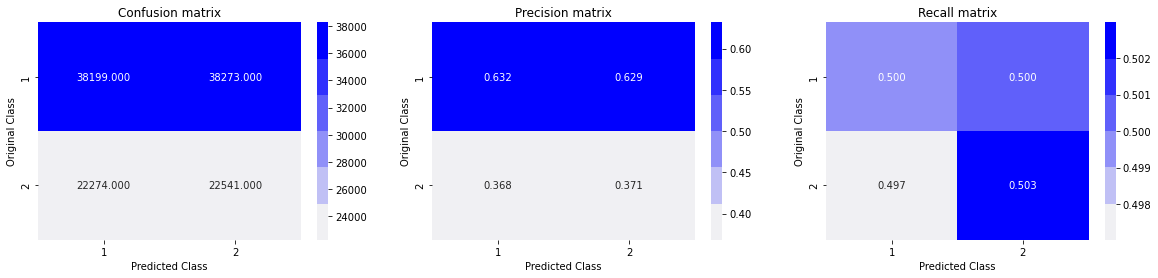

In [73]:
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

### Logistic Regression

For values of alpha =  1e-05 The log loss is: 0.38151697185225975
For values of alpha =  0.0001 The log loss is: 0.3859240484041365
For values of alpha =  0.001 The log loss is: 0.41828386356671005
For values of alpha =  0.01 The log loss is: 0.4493647134917429
For values of alpha =  0.1 The log loss is: 0.463568620781578
For values of alpha =  1 The log loss is: 0.4932245782601468
For values of alpha =  10 The log loss is: 0.5458574801765115


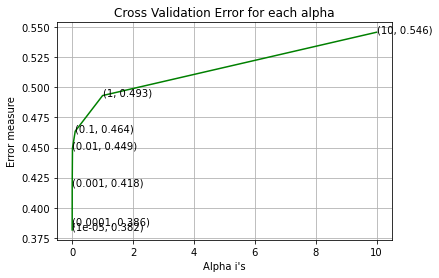

For values of best alpha =  1e-05 The train log loss is: 0.3731253171256206
For values of best alpha =  1e-05 The test log loss is: 0.38151697185225975
Total number of data points : 121287


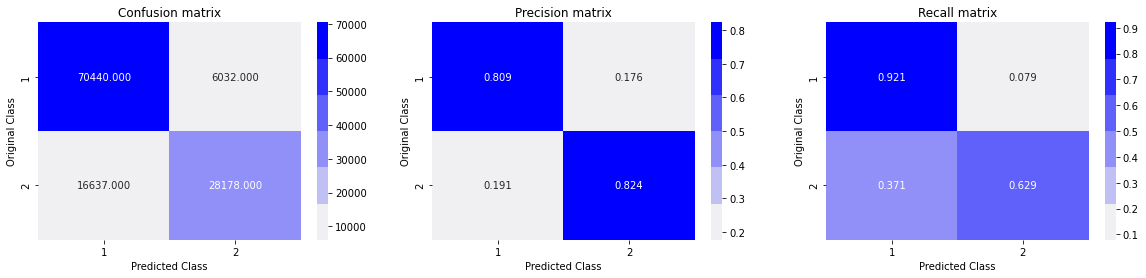

In [76]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

### Linear SVM

For values of alpha =  1e-05 The log loss is: 0.4307165590953153
For values of alpha =  0.0001 The log loss is: 0.44455130399314097
For values of alpha =  0.001 The log loss is: 0.46407113662387084
For values of alpha =  0.01 The log loss is: 0.48497212521494515
For values of alpha =  0.1 The log loss is: 0.48787367211068267
For values of alpha =  1 The log loss is: 0.5905088252744614
For values of alpha =  10 The log loss is: 0.6427004663305427


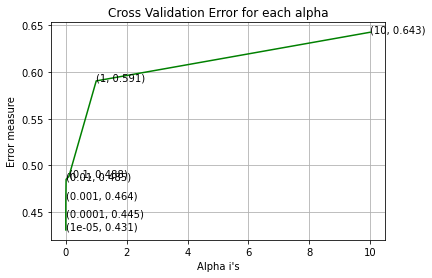

For values of best alpha =  1e-05 The train log loss is: 0.4208357648308274
For values of best alpha =  1e-05 The test log loss is: 0.4307165590953153
Total number of data points : 121287


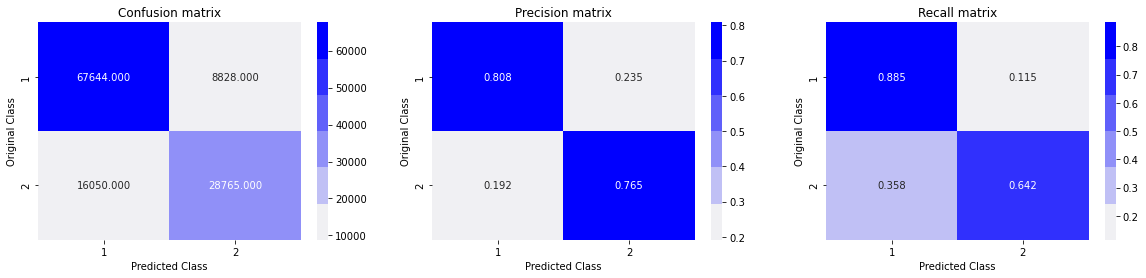

In [77]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

### Xgboost
#### Hypertuning xgboost

In [97]:
import xgboost as xgb

start = dt.datetime.now()

params = {'n_estimators' : [1,2,4,6,8,10,15,20,30,40,60],'learning_rate' :[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]}
param_grid = params

model = xgb.XGBClassifier(nthread=-1)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
random_search = RandomizedSearchCV(model, param_grid, scoring="neg_log_loss", cv=kfold, return_train_score=True)
random_search.fit(X_train,y_train)

# Summarize results

train_auc = random_search.cv_results_['mean_train_score']
train_auc_std = random_search.cv_results_['std_train_score']
cv_auc = random_search.cv_results_['mean_test_score']
cv_auc_std = random_search.cv_results_['std_test_score']
print("Best HyperParameter: ",random_search.best_params_)
print("Best Accuracy: %.2f%%"%(random_search.best_score_*100))
   
print("\nTimeTaken: ",dt.datetime.now() - start)

[10:28:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:29:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:29:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:29:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

#### Plotting hyperparamater: n_estimator vs AUC

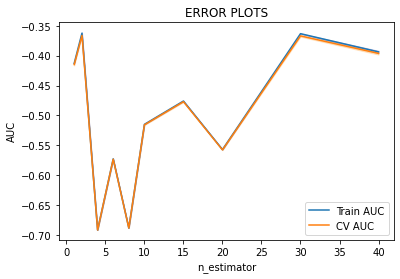

In [98]:
estimator = [1,2,4,6,8,10,15,20,30,40]
plt.plot(estimator, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(estimator,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(estimator, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(estimator,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("n_estimator")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

#### Xgboost with best n_estimator and learning rate hyperparameter

[10:43:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
For values of best alpha =  1e-05 The train log loss is: 0.36366558550955735
For values of best alpha =  1e-05 The test log loss is: 0.3659900582477126
Total number of data points : 121287


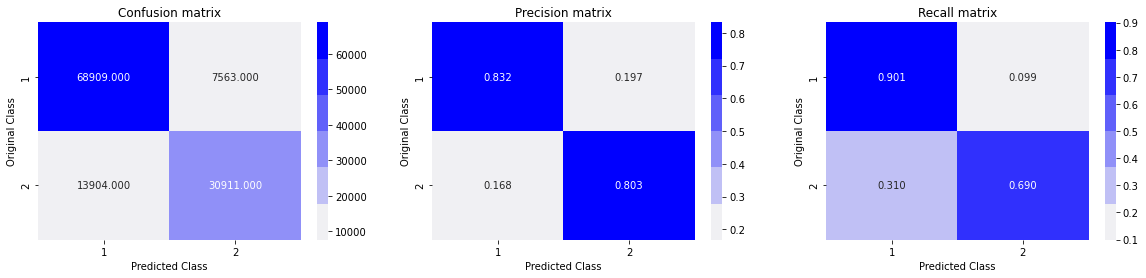

0:00:22.631496


In [101]:
start = dt.datetime.now()

xGBClassifier = xgb.XGBClassifier( 
                              learning_rate=0.1, 
                              n_estimators=30,
                              nthread=-1)
xGBClassifier.fit(X_train, y_train)

predict_y = xGBClassifier.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = xGBClassifier.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

print(dt.datetime.now() - start)

### Plotting roc curve

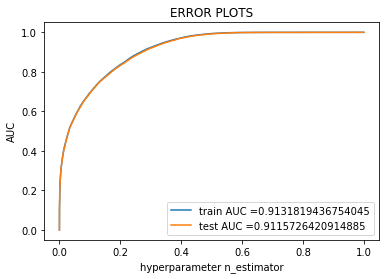

In [102]:
train_fpr, train_tpr, thresholds = roc_curve(y_train, xGBClassifier.predict_proba(X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, xGBClassifier.predict_proba(X_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("hyperparameter n_estimator")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

## Conclusion

In [105]:
from prettytable import PrettyTable
x = PrettyTable()
x.title = " Model Comparision "
x.field_names = ['Model', 'Various tokenizer','hyperparameter Tunning', 'train log loss ','test Log Loss']
x.add_row(["Random model","TFIDF","NA","NA","0.8871"])
x.add_row(["Logistic Regression","TFIDF","Done","0.44","0.45"])
x.add_row(["Linear SVM","TFIDF","Done","0.45","0.45"])
x.add_row(["xgboost","TFIDF","Done","0.36","0.36"])
print(x)

+----------------------------------------------------------------------------------------------------+
|                                         Model Comparision                                          |
+---------------------+-------------------+------------------------+-----------------+---------------+
|        Model        | Various tokenizer | hyperparameter Tunning | train log loss  | test Log Loss |
+---------------------+-------------------+------------------------+-----------------+---------------+
|     Random model    |       TFIDF       |           NA           |        NA       |     0.8871    |
| Logistic Regression |       TFIDF       |          Done          |       0.44      |      0.45     |
|      Linear SVM     |       TFIDF       |          Done          |       0.45      |      0.45     |
|       xgboost       |       TFIDF       |          Done          |       0.36      |      0.36     |
+---------------------+-------------------+------------------------+-----